In [217]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import csv, json
from sklearn.metrics import root_mean_squared_error,mean_squared_error
import numpy as np

from statsmodels.stats.weightstats import ttost_ind
import statsmodels.formula.api as smf
import statsmodels.api as sm


# Read me

This script relies on the data being chunked by "DataChunking_sigmark_overheadtest.ipynb" and that we have obtained one csv file for each of the tests. If in doubt, check your "ChunkedData" folder.

The following imports the chunked data and provides us with two dataframes:
- dfs which holds the energy data for all the test
- df_powers holds all the power measurements for all the tests

After the import, the data is ready for your 

In [221]:
input_directory = '../ChunkedData'
output_directory = '../Results/'

In [223]:
# this part reads the chunked data files related to the 

In [225]:
ls ../ChunkedData

sigmark_10_siglent.1761304296968.CH1.csv
sigmark_10_siglent.1761304909731.CH1.csv
sigmark_10_siglent.1761305564694.CH1.csv
sigmark_1_siglent.1761304296968.CH1.csv
sigmark_1_siglent.1761304909731.CH1.csv
sigmark_1_siglent.1761305564694.CH1.csv
sigmark_20_siglent.1761304296968.CH1.csv
sigmark_20_siglent.1761304909731.CH1.csv
sigmark_20_siglent.1761305564694.CH1.csv
sigmark_2_siglent.1761304296968.CH1.csv
sigmark_2_siglent.1761304909731.CH1.csv
sigmark_2_siglent.1761305564694.CH1.csv
sigmark_4_siglent.1761304296968.CH1.csv
sigmark_4_siglent.1761304909731.CH1.csv
sigmark_4_siglent.1761305564694.CH1.csv
sigmark_5_siglent.1761304296968.CH1.csv
sigmark_5_siglent.1761304909731.CH1.csv
sigmark_5_siglent.1761305564694.CH1.csv
sigmark_80_siglent.1761304296968.CH1.csv
sigmark_80_siglent.1761304909731.CH1.csv
sigmark_80_siglent.1761305564694.CH1.csv


In [227]:
pd.read_csv('../ChunkedData/sigmark_10_siglent.1761304296968.CH1.csv',nrows=1,header=0)

# we want to  keep id2, exp_duration, count as  test, exp_duration, no_of_messages

,id1,id2,start_time,channelId,exp_duration,count
0,sigmark,10,1761303887665,CH1,80174,8


In [229]:
#import all the CSV files

# (a) Read from row 3 and on into df and calculate energy consumption
# (b) Read the first two lines with meta data, add the calculated energy consumption and concat to the existing
ID = 0
list_of_metadataframes = []
list_of_dataframes = []
for input_file in os.listdir(input_directory):
    file_path = input_directory+'/'
    file_name = os.path.basename(input_file)
    if file_name.endswith('.csv'):
        df = pd.read_csv(file_path+file_name,skiprows=2, names=['timestamp','channel','action','payload'])
        # print(file_path+file_name,df['timestamp'].dtypes)
        df['time'] = (df['timestamp']-df['timestamp'].min()) / 1000
        df['ID'] = ID
        x = df['time']
        y = df['payload']
        y_int = integrate.cumulative_trapezoid(y, x, initial=0)
        #plt.plot(x, y_int)
        #plt.plot(x,y)
        #plt.savefig('')
        #plt.show()
        energy = y_int[-1]
        df_main = pd.read_csv(file_path+file_name,nrows=1,header=0,usecols = [1,4,5],names=['test','exp_duration','no_of_messages'])
        df_main['duration']=df['time'].max() # in seconds
        df_main['energy']=energy  # in joules
        df_main['power_avg']= energy/df_main['duration'] # in Watt
        df_main['ID'] = ID
        # print(df_main)
        df['test']=df_main['test'][0]
        df['no_of_messages']=df_main['no_of_messages'][0]
        df['ID'] = ID
        list_of_metadataframes.append(df_main)
        list_of_dataframes.append(df)
        ID = ID + 1

#dfs = pd.concat(list_of_metadataframes)
#df_power = pd.concat(list_of_dataframes)


In [232]:
dfs =pd.concat(list_of_metadataframes)

In [234]:
dfs = dfs.sort_values(by='test')
dfs = dfs.reset_index(drop=True)

In [236]:
dfs

,test,exp_duration,no_of_messages,duration,energy,power_avg,ID
0,1,81522,80,81.513,197.405775,2.421770,20
1,1,81331,80,81.328,197.440175,2.427702,16
2,1,81310,80,81.305,196.570950,2.417698,19
3,2,80669,40,80.664,192.901250,2.391417,6
4,2,80789,40,80.783,205.999225,2.550032,0
5,2,80658,40,80.655,192.687750,2.389037,1
6,4,80345,20,80.341,191.718125,2.386305,5
7,4,80356,20,80.344,191.180450,2.379524,11
8,4,80398,20,80.393,201.815375,2.510360,10
9,5,80309,16,80.306,190.645300,2.373986,3


In [238]:
df_powers = pd.concat(list_of_dataframes)

In [240]:
df_powers = df_powers.reset_index(drop=True)

In [242]:
df_powers

,timestamp,channel,action,payload,time,ID,test,no_of_messages
0,1761304128620,CH1,POWER,2.50,0.000,0,2,40
1,1761304128625,CH1,POWER,2.50,0.005,0,2,40
2,1761304128630,CH1,POWER,2.50,0.010,0,2,40
3,1761304128635,CH1,POWER,2.50,0.015,0,2,40
4,1761304128640,CH1,POWER,2.50,0.020,0,2,40
...,...,...,...,...,...,...,...,...
308949,1761304290923,CH1,POWER,2.35,81.492,20,1,80
308950,1761304290929,CH1,POWER,2.35,81.498,20,1,80
308951,1761304290933,CH1,POWER,2.35,81.502,20,1,80
308952,1761304290939,CH1,POWER,2.35,81.508,20,1,80


# Nilma and Jespers Evaluation

The above imports the chunked data and provides us with two dataframes:
- dfs which holds the energy data for all the test
- df_powers holds all the power measurements for all the tests

1. Ultimately, we want to find out how much energy the raspberry pi is using per tick. 
2. We need to verify whether we can trust the data. 

<Axes: xlabel='no_of_messages', ylabel='energy'>

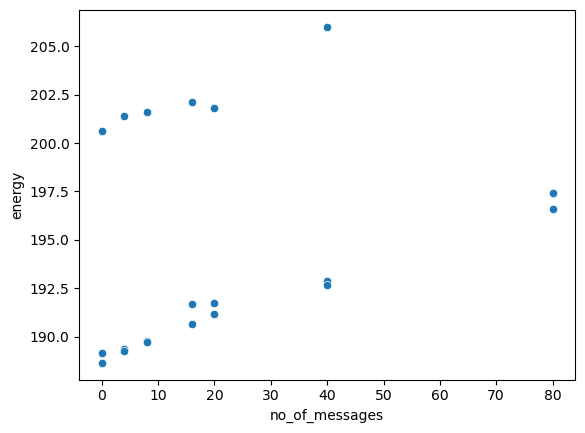

In [245]:
# first, we want to know how much energy is used for each number_of_messages

sns.scatterplot(data= dfs, x='no_of_messages',y='energy')

<Axes: xlabel='time', ylabel='payload'>

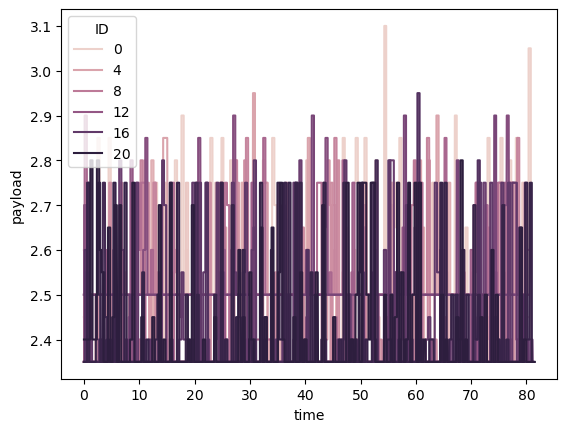

In [247]:
sns.lineplot(data=df_powers, x='time', y='payload',hue= 'ID')

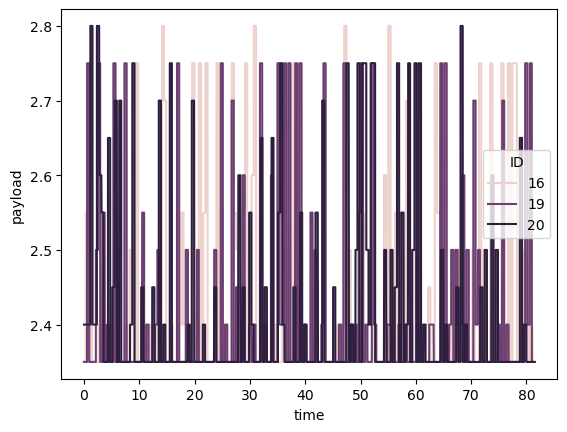

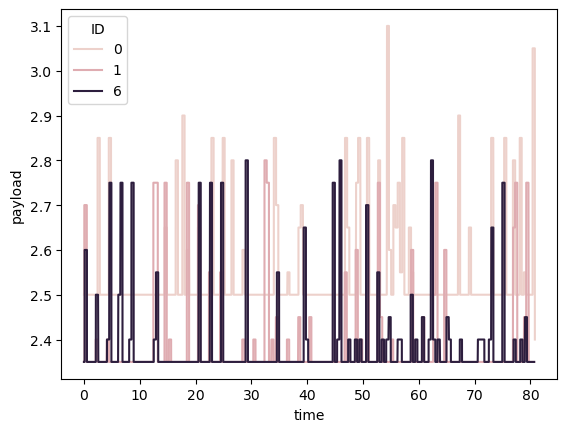

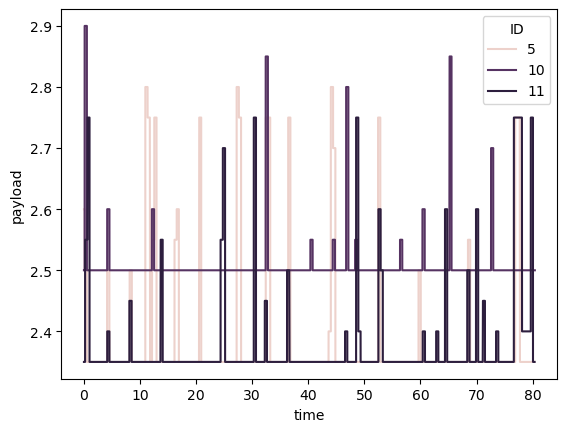

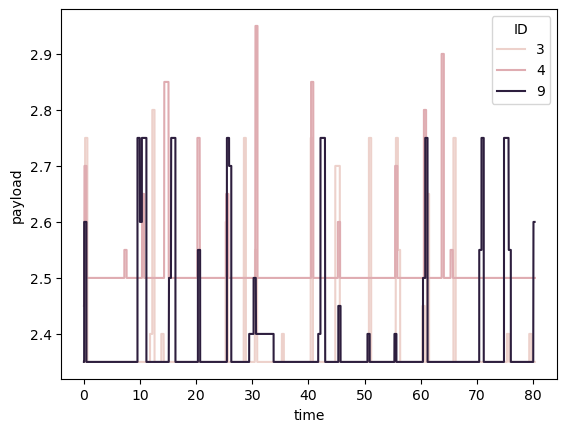

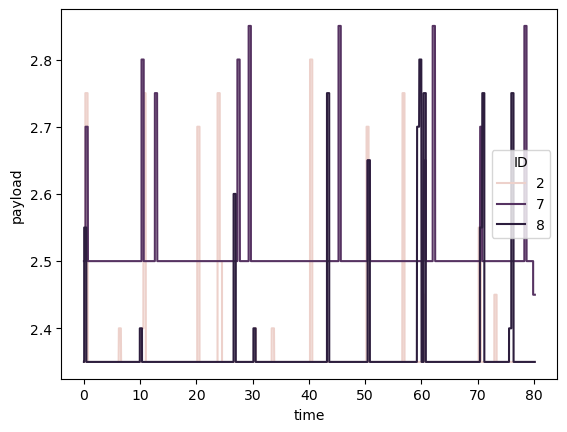

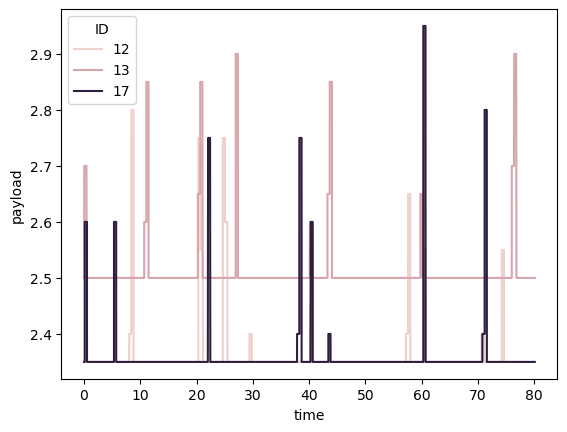

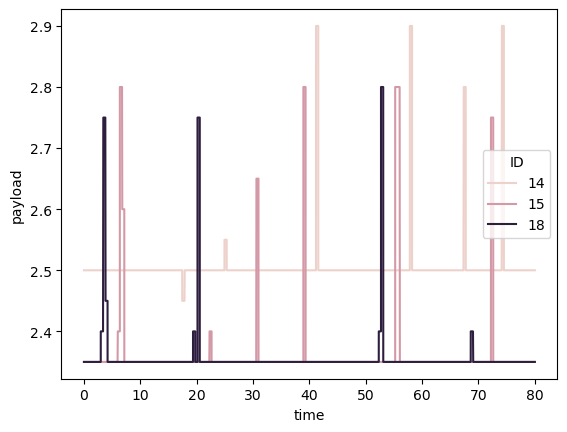

In [248]:
df_powers_groupbytest = df_powers.groupby('test')

for test_, df in df_powers_groupbytest:
    sns.lineplot(data=df, x='time', y='payload',hue= 'ID')
    plt.show()

<Axes: xlabel='timestamp', ylabel='payload'>

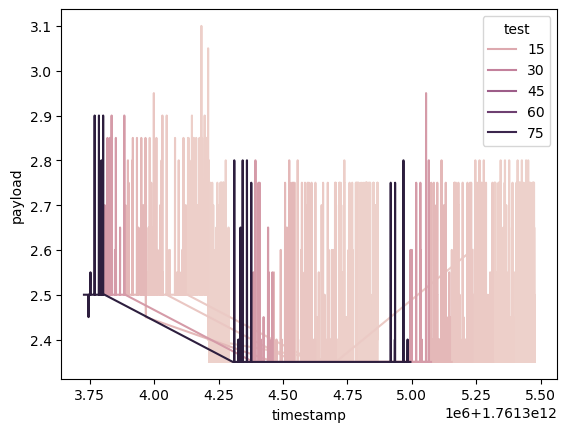

In [249]:
sns.lineplot(data=df_powers, x='timestamp', y='payload',hue= 'test')


### The Best-fit Global Model

$\text{energy} = a \cdot \text{number of messages} + b$

- $a$: baseline slope (effect of sending a message).
- $b$: global intercept (baseline energy when number of messages = 0).

R-squared (R²) is defined as a number that tells you how well the independent variable(s) in a statistical model explains the variation in the dependent variable. It ranges from 0 to 1, where 1 indicates a perfect fit of the model to the data.

While R² is often between 0 and 1, it can be negative when the model performs worse than predicting the mean of the data.

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.491
Date:                Mon, 27 Oct 2025   Prob (F-statistic):              0.237
Time:                        09:41:43   Log-Likelihood:                -64.330
No. Observations:                  21   AIC:                             132.7
Df Residuals:                      19   BIC:                             134.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        193.5019      1.619    119.

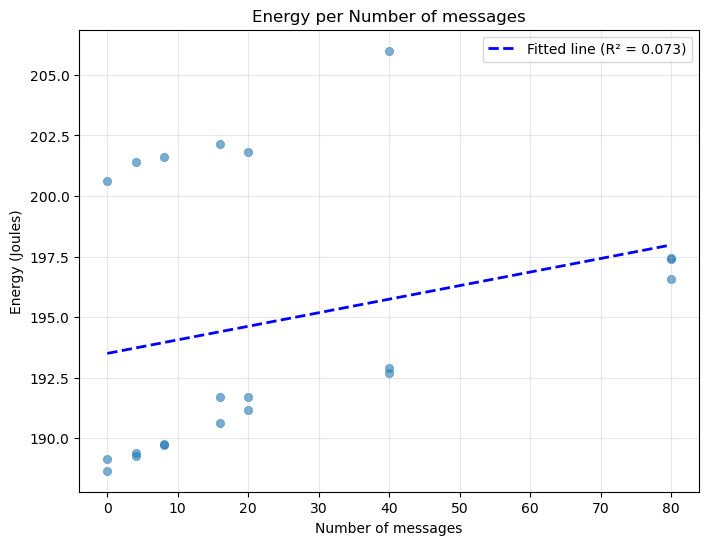

In [254]:
model = smf.ols("energy ~ no_of_messages", data=dfs).fit()
print(model.summary())

# Scatterplot of error vs duration
plt.figure(figsize=(8,6))
sns.scatterplot(x="no_of_messages", y="energy", data=dfs, alpha=0.6, edgecolor=None)

# Regression line (from statsmodels fit)
x_vals = np.linspace(dfs["no_of_messages"].min(), dfs["no_of_messages"].max(), 200)
y_vals = model.params['Intercept'] + model.params['no_of_messages']*x_vals  # from the regression model

r2_text = f"Fitted line (R² = {model.rsquared:.3f})"
plt.plot(x_vals, y_vals, color="blue", linewidth=2, linestyle='--',label=r2_text)

plt.title("Energy per Number of messages")
plt.xlabel("Number of messages")
plt.ylabel("Energy (Joules)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(output_directory+'energy_pr_no_of_message.png')
plt.show()